# ディープニューラルネットワークスクラッチ


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [3]:
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()


Using TensorFlow backend.


In [4]:
print(X_train.shape) # (60000, 28, 28)
print(X_test.shape) # (10000, 28, 28)
print(X_train[0].dtype) # uint8
print(X_train[0])

(60000, 28, 28)
(10000, 28, 28)
uint8
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   3  18  18  18 126 136
  175  26 166 255 247 127   0   0   0   0]
 [  0   0   0   0   0   0   0   0  30  36  94 154 170 253 253 253 253 253
  225 172 253 242 195  64   0   0   0   0]
 [  0   0   0   0   0   0   0  49 238 253 253 253 253 253 253 253 253 251
   93  82  82  56  39   0   0   0   0   0]
 [  0   0   0   0   0   0 

In [5]:
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)

X_train.shape
X_test.shape


(10000, 784)

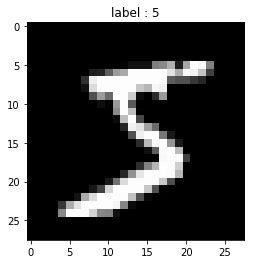

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
index = 0
image = X_train[index].reshape(28,28)
# X_train[index]: (784,)
# image: (28, 28)
plt.imshow(image, 'gray')
plt.title('label : {}'.format(y_train[index]))
plt.show()

## 前処理

In [6]:
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255
print(X_train.max()) # 1.0
print(X_train.min()) # 0.0

1.0
0.0


In [7]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_test_one_hot = enc.transform(y_test[:, np.newaxis])
print(y_train.shape) # (60000,)
print(y_train_one_hot.shape) # (60000, 10)
print(y_train_one_hot.dtype) # float64

(60000,)
(60000, 10)
float64


In [8]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train_one_hot, test_size=0.2)
print("X_train.shape =", X_train.shape)
print("X_val.shape =", X_val.shape)
print("y_train.shape =", y_train.shape)
print("y_val.shape =", y_val.shape)

X_train.shape = (48000, 784)
X_val.shape = (12000, 784)
y_train.shape = (48000, 10)
y_val.shape = (12000, 10)


## ミニバッチ処理

In [9]:
class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      訓練用データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)

    def __len__(self):
        return self._stop

    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]        

    def __iter__(self):
        self._counter = 0
        return self

    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]
    


## 層などのクラス化
クラスにまとめて行くことで、構成を変更しやすい実装にしていきます。

手を加える箇所

- 層の数
- 層の種類（今後畳み込み層など他のタイプの層が登場する）
- 活性化関数の種類
- 重みやバイアスの初期化方法
- 最適化手法


## 【問題1】全結合層のクラス化


In [10]:
class FC:
    """
    ノード数n_nodes1からn_nodes2への全結合層
    Parameters
    ----------
    n_nodes1 : int
      前の層のノード数
    n_nodes2 : int
      後の層のノード数
    initializer : 初期化方法のインスタンス
    optimizer : 最適化手法のインスタンス
    """
    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer):
        self.optimizer = optimizer
        # 初期化
        self.W = initializer.W(n_nodes1, n_nodes2)
        self.B = initializer.B(n_nodes2)
        
        
    def forward(self, X):
        """
        フォワード
        Parameters
        ----------
        X : 次の形のndarray, shape (batch_size, n_nodes1)
            入力
        Returns
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes2)
            出力
        """
        self.X = X
        A = self.X@self.W + self.B
       
        return A
    def backward(self, da):
        """
        バックワード
        Parameters
        ----------
        dA : 次の形のndarray, shape (batch_size, n_nodes2)
            後ろから流れてきた勾配
        Returns
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_nodes1)
            前に流す勾配
        """
        
        self.db = np.sum(da, axis = 0)
        self.dw = self.X.T@da
        dz = da@self.W.T
        
        # 更新
        self = self.optimizer.update(self)
        return dz



## 【問題2】初期化方法のクラス化


In [11]:
class SimpleInitializer:
    """
    ガウス分布によるシンプルな初期化
    Parameters
    ----------
    sigma : float
      ガウス分布の標準偏差
    """
    def __init__(self, sigma = 0.01):
        self.sigma = sigma
    
    def W(self, n_nodes1, n_nodes2):
        """
        重みの初期化
        バイアスの初期化
        Parameters
        ----------
        n_nodes1 : int
          前の層のノード数
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        W :
        """
        W = self.sigma * np.random.randn(n_nodes1, n_node2)
        
        return W
    
    def B(self, n_nodes2):
        """
        バイアスの初期化
        Parameters
        ----------
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        B :
        """
        B = self.sigma * np.random.randn(n_nodes2)

        return B

## 【問題3】最適化手法のクラス化


In [12]:
class SGD:
    """
    確率的勾配降下法
    Parameters
    ----------
    lr : 学習率
    """
    def __init__(self, lr):
        self.lr = lr
    
    def update(self, layer):
        """
        ある層の重みやバイアスの更新
        Parameters
        ----------
        layer : 更新前の層のインスタンス

        Returns
        ----------
        layer : 更新後の層のインスタンス
        """
        layer.W = layer.W - self.lr * layer.dw
        layer.B = layer.B - self.lr * layer.db
        
        return layer

## 【問題4】活性化関数のクラス化


In [13]:
class Sigmoid:
    
    def __init__(self):
        self.out = None
    
    def forward(self, A):
        out = 1 / (1 + np.exp(- self.A))
        self.out = out
        return self.out
    
    def backward(self, dZ):
        self.dA = dZ*(1.0 - self.out) * self.out
        return self.dA         

In [14]:
class Tanh:
    
    def __init__(self):
        self.out = None
    
    def forward(self, A):
        self.out = np.tanh(A)
        return self.out
    
    def backward(self, dZ):
        self.dA = (1 - self.out**2)*dZ
        return self.dA
        

In [15]:
class Softmax:

    def __init__(self):
        self.loss = None #損失
        self.y = None #softmax output
    
    def forward(self, A):
        self.y = np.exp(A) /np.reshape(np.sum(np.exp(A), axis=1),(-1,1))
        return self.y

    def backward(self, z, y):
        self.dA = z - y
        self.loss = -1 * (np.mean(np.sum(y*np.log(z+1e-5),axis=1),axis =0 ))

        return self.dA

In [16]:
    def cross_entropy_error(self,y):
        """
        交差エントロピー誤差の計算
        """
        if y.ndim == 1:
            y = np.reshape(y, (-1,1))
        
        self.L = -1 * (np.mean(np.sum(y*np.log(self.Z3+1e-5),axis=1),axis =0 ))


## 【問題5】ReLUクラスの作成


In [17]:
class ReLU:
    
    def __init__(self):
        self.mask = None
    
    def forward(self,X):
        self.mask = (X <= 0)
        out = X.copy()
        out[self.mask] = 0
        return out
        
    def backward(self, dout):
        dout[self.mask] = 0
        dx = dout
        return dx


## 【問題6】重みの初期値


## Xavierの初期値


In [18]:
class Xavier:
    """
    def __init__(self):
        self.n_nodes1 = n_nodes1
        self.n_nodes2 = n_nodes2
        self.sigma = 1 / np.sqrt(n_nodes1)
    """    
    def W(self, n_nodes1, n_nodes2):
        self.sigma = 1 / np.sqrt(n_nodes1)
        W = self.sigma*np.random.randn(n_nodes1, n_nodes2)
        
        return W
    
    def B(self, n_nodes2):
        B = self.sigma*np.random.randn(n_nodes2)
        
        return B

## Heの初期値

In [19]:
class He:
    """
    def __init__(self):
        
        self.n_nodes1 = n_nodes1
        self.n_nodes2 = n_nodes2
        self.sigma = np.sqrt(2 / n_nodes1)
    """
    def W(self, n_nodes1, n_nodes2):
        self.sigma = np.sqrt(2 / n_nodes1)
        W = self.sigma*np.random.randn(n_nodes1, n_nodes2)
        
        return W
    
    def B(self, n_nodes2):
        B = self.sigma*np.random.randn(n_nodes2)
        
        return B

## 【問題7】最適化手法(AdaGrad)

In [20]:
class AdaGrad:
    
    def __init__(self, lr):
        self.lr = lr
        self.hw = 1
        self.hb = 1
        
    def update(self, layer):
        self.hw = self.hw + layer.dw**2
        self.hb = self.hb + layer.db**2
        layer.W = layer.W - self.lr *(1 / np.sqrt(self.hw))* layer.dw
        layer.B = layer.B - self.lr *(1 / np.sqrt(self.hb))* layer.db
        
        return layer

## 【問題8】クラスの完成


In [21]:
class ScratchDeepNeuralNetrowkClassifier():    
    
    def __init__(self,
                 optimizer,
                 num_epoch = 3,
                 lr = 0.01,
                 batch_size = 20,
                 layer_sizes = (784,400,200,10),
                 activation = ReLU(),
                 initializer = He(),
                 verbose = False):
        
        self.optimizer = optimizer
        self.num_epoch = num_epoch
        self.lr = lr
        self.batch_size = batch_size
        self.layer_sizes = layer_sizes
        self.activation = activation
        self.initializer = initializer
        self.verbose = verbose
        
        self.num_layers = len(layer_sizes)
        
        
    def fit(self, X, y, X_val=None, y_val=None):
        """
        ニューラルネットワーク分類器を学習する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練用データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            訓練用データの正解値
        X_val : 次の形のndarray, shape (n_samples, n_features)
            検証用データの特徴量
        y_val : 次の形のndarray, shape (n_samples, )
            検証用データの正解値
        """
        
        exist_valdata = False
        if X_val is not None:
            exist_valdata = True
        
        #全結合層と活性化関数を保存
        self.FC_dict = {}
        self.activation_dict = {}
        for i in range(self.num_layers - 1):
            self.FC_dict[i] = FC(self.layer_sizes[i],
                                 self.layer_sizes[i+1],
                                 self.initializer,
                                 self.optimizer(self.lr))
            
            if i == (self.num_layers - 2):
                self.activation_dict[i] = Softmax()
            else:
                activation = copy.deepcopy(self.activation)
                self.activation_dict[i] = activation
                   
        self.loss_list = []
        self.val_loss = []
        #学習
        for i in range(self.num_epoch):            
            get_mini_batch = GetMiniBatch(X, y, batch_size=self.batch_size)
            for mini_X_train, mini_y_train in get_mini_batch:
                
                #forward
                Z = mini_X_train
                for j in range(self.num_layers - 1):
                    A = self.FC_dict[j].forward(Z)
                    Z = self.activation_dict[j].forward(A)
                    
                #backward
                dA = self.activation_dict[self.num_layers-2].backward(Z, mini_y_train)
                dZ = self.FC_dict[self.num_layers-2].backward(dA)
                for j in range(self.num_layers - 2):
                    dA = self.activation_dict[self.num_layers -j-3].backward(dZ)
                    dZ = self.FC_dict[self.num_layers -j-3].backward(dA)
                    
            #loss
            self.loss_list.append(self.activation_dict[self.num_layers-2].loss)
                    
                    
    def predict(self, X):
        Z = X
        for j in range(self.num_layers - 1):
            A = self.FC_dict[j].forward(Z)
            Z = self.activation_dict[j].forward(A)
        return np.argmax(Z, axis=1)    
        

# 検証


## 【問題9】学習と推定


In [22]:
SDN = ScratchDeepNeuralNetrowkClassifier(lr = 0.01,num_epoch=10, optimizer = AdaGrad)

In [23]:
SDN.fit(X_train, y_train)

In [24]:
SDN.loss_list

[0.48816177823319695,
 0.30111961811834476,
 0.2289085133537428,
 0.17594819844538942,
 0.1282237060789032,
 0.08403429386136796,
 0.05326940748993305,
 0.039087961443418556,
 0.02927911210218122,
 0.022110533376170027]

In [25]:
y = SDN.predict(X_test)

In [26]:
print(accuracy_score(y_test, y))

0.9801


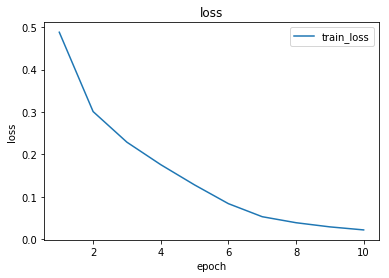

In [27]:
plt.title("loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.plot(np.arange(1, 10+1), SDN.loss_list, label="train_loss")
plt.legend()
plt.show()

In [28]:
#層を１層増やした
SDN2 = ScratchDeepNeuralNetrowkClassifier(lr = 0.01,layer_sizes = (784,400,200,200,10),num_epoch=10, optimizer = AdaGrad)

In [29]:
SDN2.fit(X_train, y_train)

In [30]:
SDN2.loss_list

[0.2830566963415781,
 0.14706969914992368,
 0.0920756565963766,
 0.05015656358904876,
 0.02826716453794001,
 0.016146078401581106,
 0.011270828014848995,
 0.008989272213754387,
 0.006911785371130049,
 0.005226306743606886]

In [31]:
y2 = SDN2.predict(X_test)

In [32]:
print(accuracy_score(y_test, y2))

0.9805


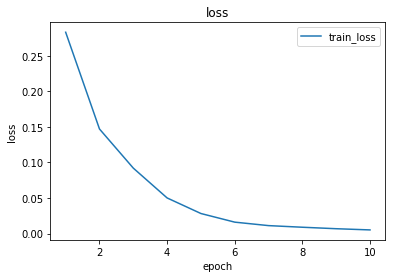

In [34]:
plt.title("loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.plot(np.arange(1, 10+1), SDN2.loss_list, label="train_loss")
plt.legend()
plt.show()